## Curvilinear grid Great Circle Interpolation of tracer points

Using [xmitgcm](https://xmitgcm.readthedocs.io/en/latest) to load `tutorial_global_oce_latlon` grid and interpolate from grid to specified lat lons (in a linearly spaced vector to start). 

Goal: save ssp and bathymetry along specified lat lons, save weights to be read in by mitgcm

In [28]:
import sandbox as sb
import numpy as np
import xarray as xr
import xmitgcm

# Plotting
import matplotlib.pyplot as plt

In [29]:
data_dir = '/home/ivana/regionalgcm/tutorial_global_oce_latlon/run'
grid_dir = data_dir

In [30]:
ds = xmitgcm.open_mdsdataset(data_dir, 
                             prefix=['ssp', 'T'], 
                             iters=[20])
ds = ds.squeeze()
ds = ds.isel(Z=0)

In [31]:
ds

<xarray.Dataset>
Dimensions:   (XC: 90, YC: 40, XG: 90, YG: 40, Zp1: 16, Zu: 15, Zl: 15)
Coordinates: (12/34)
    iter      int64 20
    time      timedelta64[ns] 00:00:20
  * XC        (XC) >f4 2.0 6.0 10.0 14.0 18.0 ... 342.0 346.0 350.0 354.0 358.0
  * YC        (YC) >f4 -78.0 -74.0 -70.0 -66.0 -62.0 ... 66.0 70.0 74.0 78.0
  * XG        (XG) >f4 0.0 4.0 8.0 12.0 16.0 ... 340.0 344.0 348.0 352.0 356.0
  * YG        (YG) >f4 -80.0 -76.0 -72.0 -68.0 -64.0 ... 64.0 68.0 72.0 76.0
    ...        ...
    maskS     (YG, XC) bool dask.array<chunksize=(40, 90), meta=np.ndarray>
    rhoRef    >f4 1.025e+03
    dxF       (YC, XC) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
    dyF       (YC, XC) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
    dxV       (YG, XG) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
    dyU       (YG, XG) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
Data variables:
    T         (YC, XC) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
    ihop_ssp  (YC, XC) >f4 dask.array<chunksize=(40, 90), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=[2...

In [32]:
def plotGRID(ds):
    lineVars = ['XC', 'YC']; i = 0
    fig, axes = plt.subplots(ncols=2)
    for var in lineVars: 
        ds[var].plot( ax=axes[i], lw=0, marker='.')
        axes[i].title.set_text(ds[var].attrs['standard_name'])
        i = i+1
    plt.tight_layout()
    plt.show()
    return None

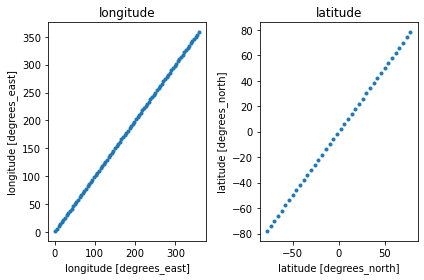

In [33]:
plotGRID(ds)

# Example: naive weight calc

assume we want weights at the point $[290.5, 35.1]^\circ$. We find the indices of the tracer point southwest of the point, and calc the normalized distances to the point, $s_{lon}, s_{lat}$

It's cheapest to store only 2 values, and we found for this grid the higher latitudes did not increase error in the linear interpolation of $s_{lon}$. Surprisingly, the $s_{lon}$ difference reduced to $\mathcal{O}(1e-7)$ at $78^\circ N$. 

In [34]:
#    XC        YC
pt = [290.5,   35.1]
pt50=[292.,    36.0]

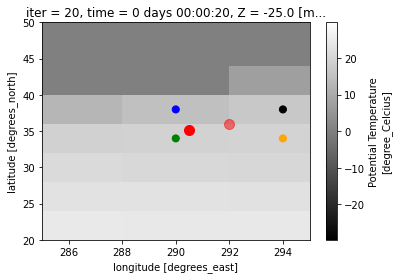

In [35]:
ds.T.plot(xlim=[285, 295], ylim=[20,50], cmap='gray')
plt.scatter(x=pt[0],y=pt[1],c='red', s=100)
plt.scatter(pt50[0],pt50[1], c='red', alpha=.5, s=100)
plt.scatter(x=[ds.XC[72], ds.XC[72], ds.XC[73], ds.XC[73]],
            y=[ds.YC[28], ds.YC[29], ds.YC[28], ds.YC[29]],
            c=['green','blue', 'orange', 'black'],s=50)
plt.show()

In [36]:
print(ds.XC[72].values, ds.YC[28].values )
print(ds.XC[73].values, ds.YC[29].values )

290.0 34.0
294.0 38.0


### Bi-curvilinear interpolation: Written like FORTRAN

remember Python is 0 indexed and FORTRAN is 1 indexed!

In [37]:
def bicurvilinInterp(ds, lon, lat):
    #Step 1: find GRID parent point indices
    i=-1
    for xc in ds.XC.values:
        if xc < lon:
            i = i+1
    if ds.XC[i+1] < lon:
        print('error: point is not contained by tracer points in lon')

    j=-1
    for yc in ds.YC.values:
        if yc < lat:
            j = j+1
    if ds.YC[j+1] < lat:
        print('error: point is not contained by tracer points in lat')

    #Step 2: Find GC distances [m] between tracer points 
    #         and to point of interest
    dlat = sb.gcDistance(ds.YC[j], ds.XC[i], ds.YC[j+1], ds.XC[i])
    dlon = sb.gcDistance(ds.YC[j], ds.XC[i], ds.YC[j],   ds.XC[i+1])

    slat = sb.gcDistance(ds.YC[j], ds.XC[i], lat,    ds.XC[i])
    slon = sb.gcDistance(ds.YC[j], ds.XC[i], ds.YC[j], lon)

    #you now have to grid weights to the pt
    wlat = slat/dlat
    wlon = slon/dlon
    
    print('weight in lat: %0.2f \nweight in lon: %0.2f'% (wlat, wlon))
    
    return i, j, wlat, wlon

In [38]:
#Step 1: Find weights
i, j, wlat, wlon = bicurvilinInterp(ds, pt[0], pt[1])

#Step 2: Calc dc along XC[i] and XC[i+1] between tracer points
dcy = ds.ihop_ssp.sel(XC=ds.XC[i], YC=ds.YC[j+1])  - \
      ds.ihop_ssp.sel(XC=ds.XC[i], YC=ds.YC[j])
dcy2 = ds.ihop_ssp.sel(XC=ds.XC[i+1], YC=ds.YC[j+1])  - \
      ds.ihop_ssp.sel(XC=ds.XC[i+1], YC=ds.YC[j])

#Step 3: Calc intermediate first linear interp on curvi in lat
cy  = ds.ihop_ssp.sel(XC=ds.XC[i],   YC=ds.YC[j]) + dcy*wlat
cy2 = ds.ihop_ssp.sel(XC=ds.XC[i+1], YC=ds.YC[j]) + dcy2*wlat

#Step 4: Calc final interp on curvilinear grid in lon
c   = (1-wlon)*cy + wlon*cy2

weight in lat: 0.28 
weight in lon: 0.13


In [39]:
print (cy.values, '\t', cy2.values, '\n\t', c.values, '\n')
print( ds.ihop_ssp.sel(XC=ds.XC[i],   YC=ds.YC[j+1]).values, '\t',
       ds.ihop_ssp.sel(XC=ds.XC[i+1], YC=ds.YC[j+1]).values, '\n|\ndcy\n|\n',
       ds.ihop_ssp.sel(XC=ds.XC[i],   YC=ds.YC[j]).values, '------',
       ds.ihop_ssp.sel(XC=ds.XC[i+1], YC=ds.YC[j]).values )

1520.2273 	 1522.2509 
	 1520.4802 

1510.252 	 1516.7739 
|
dcy
|
 1524.012 ------ 1524.3287


In [40]:
#Step 2: Calc dc along YC[j] and YC[j+1] between tracer points
dcx = ds.ihop_ssp.sel(XC=ds.XC[i+1], YC=ds.YC[j])    - \
      ds.ihop_ssp.sel(XC=ds.XC[i],   YC=ds.YC[j])
dcx2= ds.ihop_ssp.sel(XC=ds.XC[i+1], YC=ds.YC[j+1])  - \
      ds.ihop_ssp.sel(XC=ds.XC[i],   YC=ds.YC[j+1])

#Step 3: Calc intermediate first linear interp on curvi in lon
cx  = ds.ihop_ssp.sel(XC=ds.XC[i],   YC=ds.YC[j])   + dcx*wlon
cx2 = ds.ihop_ssp.sel(XC=ds.XC[i],   YC=ds.YC[j+1]) + dcx2*wlon

#Step 4: Calc final interp on curvilinear grid in lat
c2 = (1-wlat)*cx + wlat*cx2

In [41]:
print (cx2.values, '\n\t', c2.values, '\n', cx.values, '\n')
print( ds.ihop_ssp.sel(XC=ds.XC[i],   YC=ds.YC[j+1]).values, '\t',
       ds.ihop_ssp.sel(XC=ds.XC[i+1], YC=ds.YC[j+1]).values, '\n|\n',
       ds.ihop_ssp.sel(XC=ds.XC[i],   YC=ds.YC[j]).values, '- dcx -',
       ds.ihop_ssp.sel(XC=ds.XC[i+1], YC=ds.YC[j]).values )

1511.0671 
	 1520.4802 
 1524.0515 

1510.252 	 1516.7739 
|
 1524.012 - dcx - 1524.3287


In [42]:
print('Difference between dimension order of interp: O(%.1f)'% np.abs(c2.values-c.values) )

Difference between dimension order of interp: O(0.0)


This difference is perfect! But is that true only because we use a 'cartesian'ized curvilinear grid?

Let's check a finer cap grid interp with this method... load aste grid in high res
# Example : Naive interpolation with aste release1

High lats are in Face 2 of the aste grid. Load using the handy llcreader links

For llc270, the largest difference between grid points in latitude for Face 2 is _____

In [43]:
from xmitgcm import llcreader
astePt = [134.5, 76.59]
containedIn = [[200,201],[50,51]]

In [44]:
aste = llcreader.SverdrupASTE270Model()
asteDs = aste.get_dataset(k_chunksize=90)

In [45]:
ads = asteDs.sel(face=2, k=0).isel(time=0)

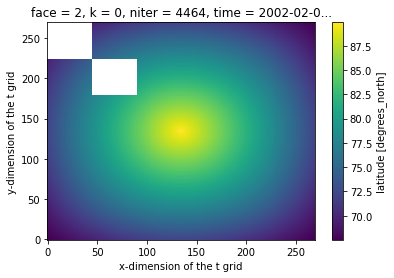

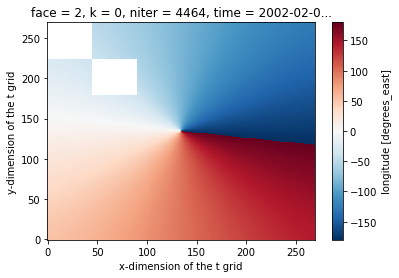

In [46]:
ads.YC.plot()

plt.figure()
ads.XC.plot()

In [47]:
def llcInterp(ds, ij, lon, lat):
    #Step 1: find GRID parent point indices
    i=ij[0]
    j=ij[1]

    #Step 2: Find GC distances [m] between tracer points 
    #         and to point of interest
    dlat = sb.gcDistance(ds.YC[j[0],i[0]], ds.XC[j[0],i[0]], \
                         ds.YC[j[1],i[0]], ds.XC[j[0],i[0]])
    dlon = sb.gcDistance(ds.YC[j[0],i[0]], ds.XC[j[0],i[0]], \
                         ds.YC[j[1],i[0]], ds.XC[j[0],i[1]])
    
    slat = sb.gcDistance(ds.YC[j[0],i[0]], ds.XC[j[0],i[0]], \
                         lat,              ds.XC[j[0],i[0]])
    slon = sb.gcDistance(ds.YC[j[0],i[0]], ds.XC[j[0],i[0]], \
                         ds.YC[j[0],i[0]], lon)

    #you now have to grid weights to the pt
    wlat = slat/dlat
    wlon = slon/dlon
    
    print('weight in lat: %0.2f \nweight in lon: %0.2f'% (wlat, wlon))
    
    return i, j, wlat, wlon

In [48]:
#Step 1: Find weights
i, j, wlat, wlon = llcInterp(ads, containedIn, astePt[0], astePt[1])

#Step 2: Calc dc along XC[i] and XC[i+1] between tracer points
dcy = ads.SALT.sel(i=i[0], j=j[1]) - \
      ads.SALT.sel(i=i[0], j=j[0])
dcy2= ads.SALT.sel(i=i[1], j=j[1]) - \
      ads.SALT.sel(i=i[1], j=j[0])

#Step 3: Calc intermediate first linear interp on curvi in lat
cy  = ads.SALT.sel(i=i[0], j=j[0]) + dcy*wlat
cy2 = ads.SALT.sel(i=i[1], j=j[0]) + dcy2*wlat

#Step 4: Calc final interp on curvilinear grid in lon
c   = (1-wlon)*cy + wlon*cy2

weight in lat: 0.03 
weight in lon: 0.18


In [49]:
print (cy.values, '\t', cy2.values, '\n\t', c.values, '\n')
print( ads.SALT.sel(i=i[0], j=j[1]).values, '\t',
       ads.SALT.sel(i=i[1], j=j[1]).values, '\n|\ndcy\n|\n',
       ads.SALT.sel(i=i[0], j=j[0]).values, '------',
       ads.SALT.sel(i=i[1], j=j[0]).values )

29.925164726630136 	 29.76991307596489 
	 29.897923051896356 

30.00943 	 29.86757 
|
dcy
|
 29.922195 ------ 29.766472


In [50]:
#Step 2: Calc dc along YC[j] and YC[j+1] between tracer points
dcx = ads.SALT.sel(i=i[1], j=j[0]) - \
      ads.SALT.sel(i=i[0], j=j[0])
dcx2= ads.SALT.sel(i=i[1], j=j[1]) - \
      ads.SALT.sel(i=i[0], j=j[1])

#Step 3: Calc intermediate first linear interp on curvi in lon
cx  = ads.SALT.sel(i=i[0], j=j[0]) + dcx*wlon
cx2 = ads.SALT.sel(i=i[0], j=j[1]) + dcx2*wlon

#Step 4: Calc final interp on curvilinear grid in lat
c2 = (1-wlat)*cx + wlat*cx2

In [51]:
print (cx2.values, '\n\t', c2.values, '\n', cx.values, '\n')
print( ads.SALT.sel(i=i[0], j=j[1]).values, '\t',
       ads.SALT.sel(i=i[1], j=j[1]).values, '\n|\n',
       ads.SALT.sel(i=i[0], j=j[0]).values, '- dcx -',
       ads.SALT.sel(i=i[1], j=j[0]).values )

29.984538227069667 
	 29.89792305189636 
 29.894870952849423 

30.00943 	 29.86757 
|
 29.922195 - dcx - 29.766472


In [52]:
print('Difference between dimension order of interp: O(%.1f)'% np.abs(c2.values-c.values) )

Difference between dimension order of interp: O(0.0)


Aste grid gives no error when you know the 4 grid points that will contain your point of interest!

Bilinear interpolation is good in as a first look into to data, but is not good enough for generating weights for an **ihop** acoustic run. 

<sub>Written by Escobar, I. September 2022</sub>